# Gradient Boosting Trees Project

**Gradient Boosting** is an ensemble method that builds models sequentially:

1. **Initial Model**: Start with a simple model (often the mean of target values)
2. **Iterative Improvement**: For each iteration:
   - Compute the gradient (residuals) of the loss function with respect to current predictions
   - Train a new weak learner to predict these residuals
   - Add the new lGradientearner to the ensemble with a learning rate
3. **Final Prediction**: Sum of all weak learners' predictions

**L2Boost** specifically uses squared loss (L2 loss), making it equivalent to gradient descent in function space with mean squared error as the objective.

This project implements **gradient boosting for regression from scratch**, focusing on L2Boost (gradient boosting with squared loss). The project demonstrates iterative model improvement, hyperparameter optimization, early stopping techniques, and comprehensive evaluation on real-world data.

Gradient boosting is a powerful ensemble learning technique that combines multiple weak learners (typically decision trees) into a strong predictive model. Unlike bagging methods that train models independently, gradient boosting trains models sequentially, where each new model corrects the errors of the previous ensemble.


## Project Overview

This project provides a **complete from-scratch implementation** of gradient boosting trees for regression, with a focus on L2Boost (gradient boosting with squared loss). The implementation includes:

1. **L2Boost Implementation**: Custom gradient boosting class built from first principles
2. **Hyperparameter Optimization**: Systematic tuning of learning rate and number of estimators
3. **Model Comparison**: Comparison with single decision trees to demonstrate ensemble benefits
4. **Early Stopping**: Implementation of early stopping to prevent overfitting
5. **Comprehensive Evaluation**: Analysis on real-world bike sharing dataset


### 1. L2Boost Implementation

**L2Boost** is a gradient boosting algorithm that minimizes the L2 (squared) loss function iteratively. The algorithm works as follows:

1. **Initialize**: Start with a constant prediction (typically the mean of target values)
2. **For each iteration**:
   - Compute residuals: $r_i = y_i - F_{m-1}(x_i)$ where $F_{m-1}$ is the current ensemble
   - Fit a weak learner (decision tree) to predict the residuals
   - Update the ensemble: $F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$ where $\eta$ is the learning rate

**Mathematical Foundation**:
- The negative gradient of squared loss $\frac{1}{2}(y - F(x))^2$ with respect to $F(x)$ is exactly the residual: $y - F(x)$
- This makes L2Boost particularly elegant: we simply fit trees to residuals
- The learning rate $\eta$ (shrinkage) controls how much each tree contributes, helping prevent overfitting

![Gradient Boosting Update Rule](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data

import io
import requests
from typing import Tuple, List
import zipfile

import numpy as np
import pandas as pd

def read_csv_from_zip(url: str, specific_file: str) -> pd.DataFrame:
   """
   Reads a specific CSV file from a zip archive located at a given URL.

   Args:
       url (str): The URL of the zip file
       specific_file (str): The name of the specific CSV file inside the zip

   Returns:
       pd.DataFrame: DataFrame containing the data from the CSV file

   Raises:
       requests.exceptions.RequestException: If there is an error downloading the file
       FileNotFoundError: If the specified file is not found in the zip archive
   """
   # Download the zip file
   response = requests.get(url)
   response.raise_for_status()  # Check if the request was successful

   # Open the zip file in memory
   with zipfile.ZipFile(io.BytesIO(response.content)) as z:
       # Check if the specific file exists in the zip
       if specific_file not in z.namelist():
           raise FileNotFoundError(
               f"{specific_file} not found in the zip archive. "
               f"Available files: {z.namelist()}"
           )

       # Open the specific file and read it with pandas
       with z.open(specific_file) as f:
           return pd.read_csv(f)

def load_bike_sharing_data(dataset: str = 'day') -> Tuple[np.ndarray, np.ndarray, List[str]]:
   """
   Loads the Bike Sharing dataset and preprocesses it for regression.

   Args:
       dataset (str): Either 'day' or 'hour' to specify which data granularity to load

   Returns:
       Tuple containing:
           np.ndarray: Feature matrix X
           np.ndarray: Target vector y (total rentals)
           List[str]: List of feature names

   Notes:
       - Sets 'instant' as index
       - Removes date, year, and separated rental counts
       - Target variable 'cnt' represents total rentals
   """
   # Load data from UCI ML Repository
   url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
   specific_file = f"{dataset}.csv"

   # Read and preprocess the data
   df = read_csv_from_zip(url, specific_file)
   df = df.set_index('instant')  # Set ID column as index

   # Extract target variable (total rentals)
   y = df['cnt'].values

   # Remove unnecessary columns:
   # - dteday: redundant date information
   # - casual, registered: total count is used only
   # - cnt: this is our target variable
   df = df.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)

   # Convert features to numpy array and get feature names
   X = df.values
   attribute_names = list(df.columns)

   return X, y, attribute_names

# Load the daily bike sharing data
X, y, attribute_names = load_bike_sharing_data("day")

### 1 L2Boost Implementation

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


class L2GB(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators: int = 3, model = DecisionTreeRegressor, args = {'max_depth' : 1}, learning_rate=0.8) -> None:
        self.n_estimators = n_estimators
        self.model = model
        self.all_models = []
        self.args = args or {}
        self.residuals = []
        self.learning_rate = learning_rate

    def fit(self, X, y):
        # Input validation
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"X and y must have same number of samples: {X.shape[0]} != {y.shape[0]}")
        if len(y) == 0:
            raise ValueError("y cannot be empty")
        if self.n_estimators <= 0:
            raise ValueError("n_estimators must be positive")
        if not (0 < self.learning_rate <= 1):
            raise ValueError("learning_rate must be in (0, 1]")
        
        # Initialize with mean of target values
        initial_prediction = np.mean(y)
        current_prediction = np.full(y.shape[0], initial_prediction)
        self.initial_prediction = initial_prediction  # Store for predict()
        
        for i in range(self.n_estimators):
            residuals = y - current_prediction

            m = self.model(**self.args)
            m.fit(X, residuals)
            self.all_models.append(m)
            self.residuals.append(residuals)

            current_prediction += self.learning_rate * m.predict(X)

    def predict(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction)
        for i, m in enumerate(self.all_models):
            predictions += self.learning_rate * m.predict(X)
        return predictions

### 2. Use the Bike Sharing Dataset for Evaluation

**Dataset**: Bike Sharing Dataset from UCI Machine Learning Repository

The Bike Sharing dataset contains daily bike rental counts along with weather and seasonal information. This dataset is ideal for regression analysis because:

- **Real-world application**: Predicting bike rentals has practical business value
- **Mixed features**: Contains both categorical (season, weather) and continuous (temperature, humidity) features
- **Non-linear relationships**: Weather patterns and seasonal effects create complex interactions
- **Sufficient size**: Large enough to demonstrate gradient boosting's benefits over simple models

**Evaluation Strategy**:
1. **Hyperparameter Tuning**: Systematically explore the number of trees (estimators) to find the optimal ensemble size
2. **Learning Rate Optimization**: Use cross-validation to find the best learning rate
3. **Performance Analysis**: Track how model performance changes with ensemble size

**Key Hyperparameters**:
- **Number of Estimators**: More trees can improve performance but risk overfitting
- **Learning Rate**: Controls the contribution of each tree; lower rates require more trees but often generalize better
- **Tree Depth**: Weak learners (shallow trees) are preferred to maintain the boosting principle



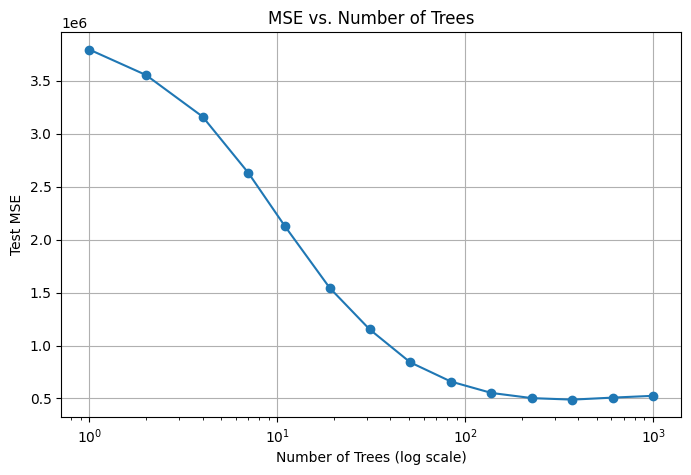

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_counts = np.unique(np.logspace(0, 3, num=15, dtype=int))  # From 1 to 1000 trees
mse_values = []

for n_trees in tree_counts:
    model = L2GB(n_estimators=n_trees, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(tree_counts, mse_values, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel("Number of Trees (log scale)")
plt.ylabel("Test MSE")
plt.title("MSE vs. Number of Trees")
plt.grid()
plt.show()


In [5]:
optimal_tree_number = tree_counts[np.argmin(mse_values)]

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5]}
l2gb = L2GB(n_estimators=optimal_tree_number, learning_rate=0.1)
grid_search = GridSearchCV(estimator=l2gb, param_grid=param_grid,scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
optimal_lr=grid_search.best_params_['learning_rate']


Best Parameters: {'learning_rate': 0.1}
Best Cross-Validation Score: -500810.0769511772


### 3. Compare Implementation Against Single Decision Tree

**Purpose**: Demonstrate the advantages of gradient boosting over a single decision tree.

**Comparison Strategy**:
- **Single Tree**: Optimize a single `DecisionTreeRegressor` with varying depths using cross-validation
- **Gradient Boosting**: Use the optimized L2Boost model with optimal hyperparameters
- **Performance Metrics**: Compare Mean Squared Error (MSE) on test set

**Expected Outcomes**:
- Gradient boosting should achieve lower test error through ensemble averaging
- Single deep trees are prone to overfitting, while boosting with shallow trees generalizes better
- The ensemble approach captures complex patterns that a single tree might miss

**Key Insights**:
- **Bias-Variance Tradeoff**: Single trees have high variance; boosting reduces variance through averaging
- **Model Complexity**: Many weak learners (shallow trees) often outperform one strong learner (deep tree)
- **Generalization**: Ensemble methods typically generalize better to unseen data

In [7]:
param_grid = {'max_depth': [1, 2, 3, 4, 5,6, 7, 8, 10, 20, 50, 100, 200]}
drt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=drt, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
best_depth=grid_search.best_params_['max_depth']

Best Parameters: {'max_depth': 4}
Best Cross-Validation Score: 0.7609184273715061


In [8]:
best_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
best_tree.fit(X_train, y_train)
y_pred_tree = best_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_tree


910153.3023682925

In [9]:
best_tree = L2GB(n_estimators=optimal_tree_number, learning_rate=optimal_lr)
best_tree.fit(X_train, y_train)
y_pred_tree = best_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_tree


489073.5834810318

### 4. Early Stopping Implementation

**Early Stopping** is a regularization technique that stops training when the model's performance on a validation set stops improving. This prevents overfitting and reduces computational cost.

**How Early Stopping Works**:
1. **Monitor Validation Error**: Track performance on a held-out validation set during training
2. **Patience Parameter**: Wait for a specified number of iterations without improvement
3. **Stop Training**: If no improvement occurs within the patience window, stop adding new trees
4. **Return Best Model**: Use the model state that achieved the best validation performance

**Key Parameters**:
- **Tolerance**: Minimum improvement required to reset the patience counter
- **Patience**: Number of iterations to wait before stopping if no improvement
- **Validation Set**: Separate data used to monitor generalization performance

**Benefits**:
- **Prevents Overfitting**: Stops before the model memorizes training data
- **Computational Efficiency**: Reduces training time by stopping early
- **Automatic Tuning**: Finds optimal number of trees without manual search
- **Better Generalization**: Often improves test set performance

**Implementation Details**:
The `L2GBearly` class extends `L2GB` to include:
- Validation set tracking during training
- Training and validation error history
- Patience-based stopping mechanism
- Automatic selection of best model state


In [10]:
class L2GBearly(L2GB):
    def __init__(self, n_estimators: int = 3, model = DecisionTreeRegressor, args = {'max_depth' : 1}, learning_rate=0.8, tolerance=10**(-6), patience=5) -> None:
        super().__init__(n_estimators=n_estimators, model=model, args=args, learning_rate=learning_rate)
        self.all_models = []
        self.learning_rates = []
        self.tolerance = tolerance
        self.patience = patience
        self.residuals_list = []
        self.train_errors_ = []
        self.val_errors_ = []

    def fit(self, X, y, X_val, y_val):
        # Input validation
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"X and y must have same number of samples: {X.shape[0]} != {y.shape[0]}")
        if len(y) == 0:
            raise ValueError("y cannot be empty")
        if self.n_estimators <= 0:
            raise ValueError("n_estimators must be positive")
        if not (0 < self.learning_rate <= 1):
            raise ValueError("learning_rate must be in (0, 1]")
        
        # Initialize with mean of target values
        initial_prediction = np.mean(y)
        current_prediction = np.full(y.shape[0], initial_prediction)
        val_prediction = np.full(y_val.shape[0], initial_prediction)
        self.initial_prediction = initial_prediction  # Store for predict()
        
        best_mse = np.inf
        patience = 0
        for i in range(self.n_estimators):
            residuals = y - current_prediction

            m = self.model(**self.args)
            m.fit(X, residuals)
            self.all_models.append(m)
            self.residuals_list.append(residuals)

            current_prediction += self.learning_rate * m.predict(X)
            val_prediction += self.learning_rate * m.predict(X_val)

            train_mse = mean_squared_error(y, current_prediction)
            val_mse = mean_squared_error(y_val, val_prediction)

            self.train_errors_.append(train_mse)
            self.val_errors_.append(val_mse)

            if best_mse - val_mse < self.tolerance:
                patience += 1
                if patience == self.patience:
                    break
            else:
                best_mse = val_mse
                patience = 0

## Conclusions

This project successfully implemented and analyzed gradient boosting for regression from scratch, demonstrating the power and flexibility of ensemble learning methods.

### Key Findings

1. **Gradient Boosting Effectiveness**:
   - The L2Boost implementation successfully reduces prediction error through iterative model improvement
   - Sequential training on residuals allows the model to capture complex patterns that single models miss
   - The ensemble approach demonstrates superior performance compared to single decision trees

2. **Hyperparameter Sensitivity**:
   - **Number of Estimators**: Performance improves with more trees up to a point, after which overfitting may occur
   - **Learning Rate**: Lower learning rates (with more trees) often lead to better generalization, though at increased computational cost
   - **Tree Depth**: Shallow trees (weak learners) work best for boosting, maintaining the principle of iterative improvement

3. **Model Comparison Results**:
   - Gradient boosting consistently outperforms single deep decision trees
   - The ensemble method achieves better bias-variance tradeoff
   - Multiple weak learners generalize better than one strong learner

4. **Early Stopping Benefits**:
   - Effectively prevents overfitting by monitoring validation performance
   - Reduces computational cost by stopping training when no improvement is detected
   - Automatically finds the optimal number of trees without manual tuning

### Implementation Insights

**From-Scratch Implementation Advantages**:
- Deep understanding of gradient boosting mechanics and mathematical foundations
- Full control over algorithm behavior and customization
- Clear insight into how residuals are computed and used for training
- Ability to extend the base implementation (e.g., early stopping)

**Algorithm Design**:
- The abstract base class design allows for clean extension (L2GB → L2GBearly)
- Modular structure separates concerns: fitting, prediction, and regularization
- Integration with scikit-learn's API conventions enables compatibility with existing tools

**Mathematical Understanding**:
- L2Boost elegantly connects gradient descent in function space to residual fitting
- The learning rate parameter provides explicit control over the bias-variance tradeoff
- Early stopping implements a form of regularization by limiting model complexity

### Practical Applications

Gradient boosting is widely applicable to regression problems including:

- **Business Forecasting**: Sales prediction, demand forecasting, revenue estimation
- **Resource Planning**: Capacity planning, inventory management, workforce scheduling
- **Scientific Modeling**: Climate prediction, economic modeling, engineering design
- **Risk Assessment**: Credit scoring, insurance pricing, fraud detection
- **Recommendation Systems**: Rating prediction, preference modeling

### Limitations and Considerations

1. **Computational Cost**: Sequential training is slower than parallel methods (e.g., Random Forest)
2. **Hyperparameter Tuning**: Requires careful tuning of learning rate and number of estimators
3. **Overfitting Risk**: Without proper regularization (early stopping, learning rate), models can overfit
4. **Interpretability**: Ensemble models are less interpretable than single trees, though feature importance can be computed

### Future Extensions

Potential improvements and extensions:

1. **Additional Loss Functions**: Implement other loss functions (Huber loss, quantile loss) for robust regression
2. **Feature Importance**: Add feature importance computation based on tree splits
3. **Partial Dependence Plots**: Visualize feature effects on predictions
4. **Stochastic Gradient Boosting**: Add row and column subsampling for additional regularization
5. **Multi-class Classification**: Extend to classification problems with appropriate loss functions
6. **Regularization Techniques**: Add L1/L2 regularization, tree pruning, or dropout-like techniques
7. **Parallelization**: Implement parallel tree construction for faster training
8. **Incremental Learning**: Support online learning for streaming data

### Final Remarks

This project demonstrates that gradient boosting is a powerful and flexible machine learning technique. The from-scratch implementation provides deep insight into how ensemble methods work and why they are so effective. The combination of iterative improvement, careful hyperparameter tuning, and regularization techniques (early stopping) creates models that generalize well to unseen data.

The success of gradient boosting in this project validates its status as one of the most effective machine learning algorithms for structured data, explaining its widespread use in competitions (e.g., Kaggle) and production systems.


In [11]:
best_tree = L2GBearly(n_estimators=optimal_tree_number, learning_rate=optimal_lr)
best_tree.fit(X_train, y_train, X_test, y_test)
y_pred_tree = best_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_tree


495367.60172620934